In [ ]:
import numpy as np 
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import layers
from keras.layers import *
from keras.utils import np_utils
from tqdm import tqdm

In [ ]:
train_df = pd.read_csv('/content/emnist-balanced-train.csv', header=None)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_df.shape

(112800, 785)

### Split train dataframe into X & y

In [ ]:
X_train = train_df.loc[:, 1:]
y_train = train_df.loc[:, 0]

X_train.shape, y_train.shape

((112800, 784), (112800,))

In [ ]:
X_train.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
y_train.head()

0    45
1    36
2    43
3    15
4     4
Name: 0, dtype: int64

### Create label dictionary

In [ ]:
label_map = pd.read_csv("/content/emnist-balanced-mapping.txt", 
                        delimiter = ' ', 
                        index_col=0, 
                        header=None, 
                        squeeze=True)
label_map.head()

0
0    48
1    49
2    50
3    51
4    52
Name: 1, dtype: int64

In [ ]:
label_dictionary = {}
for index, label in enumerate(label_map):
    label_dictionary[index] = chr(label)

label_dictionary

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'd',
 39: 'e',
 40: 'f',
 41: 'g',
 42: 'h',
 43: 'n',
 44: 'q',
 45: 'r',
 46: 't'}

### Visualize sample data

In [ ]:
# Sample entry number 40
sample_image = X_train.iloc[40]
sample_label = y_train.iloc[40]
sample_image.shape, sample_label

((784,), 25)

In [ ]:
W = 28
H = 28

Label entry 40: P


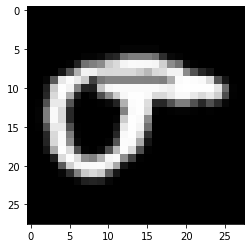

In [ ]:
print("Label entry 40:", label_dictionary[sample_label])
plt.imshow(sample_image.values.reshape(W, H), cmap=plt.cm.gray)
plt.show()

Label entry 42: P


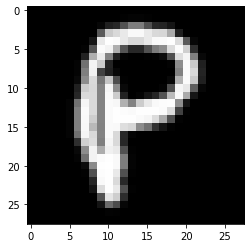

In [ ]:
def reshape_and_rotate(image):
    W = 28
    H = 28
    image = image.reshape(W, H)
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

print("Label entry 42:", label_dictionary[sample_label])
plt.imshow(reshape_and_rotate(sample_image.values), cmap=plt.cm.gray)
plt.show()

Next we want to apply reshape_and_rotate to all images in X_train

In [ ]:
# note: np.apply_along_axis returns a numpy array, X_train is not a pandas.DataFrame anymore
X_train = np.apply_along_axis(reshape_and_rotate, 1, X_train.values)
X_train.shape

(112800, 28, 28)

## Visualize more sample

Label entry 42: P


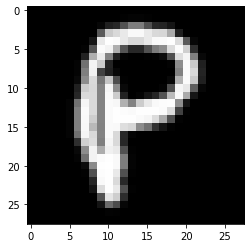

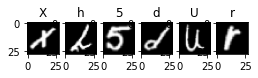

In [ ]:
sample_image = X_train[40]
sample_label = y_train.iloc[40]
print("Label entry 42:", label_dictionary[sample_label])
plt.imshow(sample_image.reshape(W, H), cmap=plt.cm.gray)
plt.show()


for i in range(100, 106):
    plt.subplot(390 + (i+1))
    plt.imshow(X_train[i], cmap=plt.cm.gray)
    plt.title(label_dictionary[y_train[i]])

Looks good

### Normalize Data

In [ ]:
X_train = X_train.astype('float32') / 255

### One Hot Encode Label

In [ ]:
number_of_classes = y_train.nunique()
number_of_classes

47

In [ ]:
y_train = np_utils.to_categorical(y_train, number_of_classes)
y_train.shape

(112800, 47)

In [ ]:
y_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
# Reshape to fit model input shape
# Tensorflow (batch, width, height, channels)
X_train = X_train.reshape(-1, W, H, 1)
X_train.shape

(112800, 28, 28, 1)

In [ ]:
# Split 10% validation 
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size= 0.1, 
                                                  random_state=88)

### Define model

In [ ]:
model = Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(W, H, 1)))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(84, activation='relu'))
model.add(layers.Dense(number_of_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 48)        38448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 48)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 256)               3

In [ ]:
optimizer_name = 'adam'

model.compile(loss='categorical_crossentropy', optimizer=optimizer_name, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
mcp_save = ModelCheckpoint('my_model.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='auto')

In [ ]:
history = model.fit(X_train,
                    y_train, 
                    epochs=30, 
                    batch_size=32, 
                    verbose=1, 
                    validation_split=0.1,
                    callbacks=[early_stopping, mcp_save])

Epoch 1/30
2855/2856 [============================>.] - ETA: 0s - loss: 0.6428 - accuracy: 0.7902
Epoch 00001: val_loss improved from inf to 0.41046, saving model to my_model.h5
2856/2856 [==============================] - 167s 58ms/step - loss: 0.6428 - accuracy: 0.7902 - val_loss: 0.4105 - val_accuracy: 0.8529
Epoch 2/30
2855/2856 [============================>.] - ETA: 0s - loss: 0.3759 - accuracy: 0.8642
Epoch 00002: val_loss improved from 0.41046 to 0.35006, saving model to my_model.h5
2856/2856 [==============================] - 153s 54ms/step - loss: 0.3759 - accuracy: 0.8642 - val_loss: 0.3501 - val_accuracy: 0.8778
Epoch 3/30
2855/2856 [============================>.] - ETA: 0s - loss: 0.3231 - accuracy: 0.8806
Epoch 00003: val_loss improved from 0.35006 to 0.33876, saving model to my_model.h5
2856/2856 [==============================] - 142s 50ms/step - loss: 0.3231 - accuracy: 0.8806 - val_loss: 0.3388 - val_accuracy: 0.8776
Epoch 4/30
2855/2856 [============================

In [ ]:
# plot accuracy and loss
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

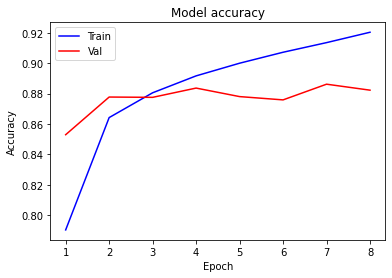

In [ ]:
# Accuracy curve
plotgraph(epochs, acc, val_acc)

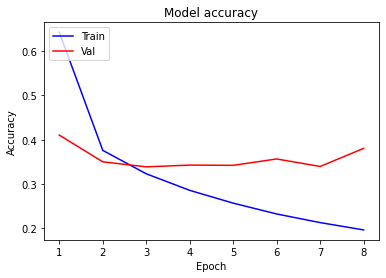

In [ ]:
# loss curve
plotgraph(epochs, loss, val_loss)

### Test model

In [ ]:
# Load best model
model = load_model('/content/my_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 48)        38448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 48)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 256)               3

In [ ]:
y_pred = model.predict(X_val)
y_pred.shape

(11280, 47)

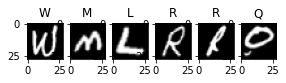

In [ ]:
for i in range(10, 16):
    plt.subplot(380 + (i%10+1))
    plt.imshow(X_val[i].reshape(28, 28), cmap=plt.cm.gray)
    plt.title(label_dictionary[y_pred[i].argmax()])

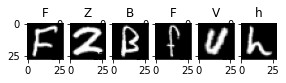

In [ ]:
for i in range(42, 48):
    plt.subplot(380 + (i%10+1))
    plt.imshow(X_val[i].reshape(28, 28), cmap=plt.cm.gray)
    plt.title(label_dictionary[y_pred[i].argmax()])

#### Test accuracy

In [ ]:
model.evaluate(X_val, y_val)

353/353 [==============================] - 5s 15ms/step - loss: 0.3664 - accuracy: 0.8684


[0.36636555194854736, 0.8684397339820862]

### Load test dataset & preprocess image like how we did to train dataset

In [ ]:
test_df = pd.read_csv('/content/emnist-balanced-test.csv', header=None)
test_df.shape

(18800, 785)

In [ ]:
test_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
count,18800.000000,18800.0,18800.0,18800.0,18800.0,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.0,18800.0,18800.0,18800.0,18800.0,18800.0,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,...,18800.00000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.000000,18800.0,18800.0,18800.0,18800.0,18800.0,18800.0,18800.0,18800.000000,18800.000000,18800.0,18800.0,18800.000000,18800.000000,18800.000000,18800.0,18800.0,18800.0,18800.0,18800.0,18800.0,18800.0,18800.0,18800.0,18800.0,18800.0,18800.0,18800.0,18800.0,18800.0
mean,23.000000,0.0,0.0,0.0,0.0,0.006064,0.019734,0.011277,0.009362,0.011277,0.005160,0.000213,0.000106,0.000213,0.000479,0.003723,0.008989,0.012287,0.030638,0.026915,0.020426,0.020426,0.014787,0.011755,0.0,0.0,0.0,0.0,0.0,0.0,0.000053,0.003723,0.027394,0.078989,0.171277,0.214202,0.242660,0.222553,0.216915,0.202234,...,0.19133,0.181330,0.176543,0.147606,0.110426,0.078670,0.068723,0.039202,0.021862,0.005745,0.000266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002872,0.000957,0.0,0.0,0.000053,0.001702,0.000266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,13.565021,0.0,0.0,0.0,0.0,0.528828,1.761298,1.054441,0.892318,1.517275,0.657402,0.023063,0.014586,0.029173,0.065639,0.387840,0.965203,1.291458,2.314176,2.259560,1.848513,1.742143,1.802969,1.611808,0.0,0.0,0.0,0.0,0.0,0.0,0.007293,0.217063,0.775197,1.649475,3.674017,4.085308,4.215629,3.494563,3.664354,3.420190,...,2.69280,2.840952,2.701914,2.428546,1.873815,1.460086,1.522692,0.770144,0.575767,0.282415,0.036466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.352798,0.131278,0.0,0.0,0.007293,0.233384,0.036466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,11.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,23.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,35.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000

In [ ]:
X_test = test_df.loc[:, 1:]
y_test = test_df.loc[:, 0]

X_test.shape, y_test.shape

((18800, 784), (18800,))

In [ ]:
X_test = np.apply_along_axis(reshape_and_rotate, 1, X_test.values)
y_test = np_utils.to_categorical(y_test, number_of_classes)

X_test.shape, y_test.shape

((18800, 28, 28), (18800, 47))

In [ ]:
X_test = X_test.astype('float32') / 255

In [ ]:
X_test = X_test.reshape(-1, W, H, 1)
X_test.shape

(18800, 28, 28, 1)

In [ ]:
model.evaluate(X_test, y_test)

588/588 [==============================] - 9s 16ms/step - loss: 0.3721 - accuracy: 0.8716


[0.3721325993537903, 0.871648907661438]